In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

In [3]:
!wget $data

--2025-11-09 01:30:06--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
185.199.108.133, 185.199.109.133, 185.199.110.133, ...tent.com)... 
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv.2’

car_fuel_efficiency 100%[===================>] 853.70K  5.16MB/s    in 0.2s    

2025-11-09 01:30:06 (5.16 MB/s) - ‘car_fuel_efficiency.csv.2’ saved [874188/874188]



In [4]:
df = pd.read_csv(data)

In [5]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [6]:
df.dtypes

engine_displacement      int64
num_cylinders          float64
horsepower             float64
vehicle_weight         float64
acceleration           float64
model_year               int64
origin                  object
fuel_type               object
drivetrain              object
num_doors              float64
fuel_efficiency_mpg    float64
dtype: object

In [7]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [8]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical

['origin', 'fuel_type', 'drivetrain']

In [9]:
numerical = list(df.select_dtypes(include=['int64', 'float64']).columns)
numerical

['engine_displacement',
 'num_cylinders',
 'horsepower',
 'vehicle_weight',
 'acceleration',
 'model_year',
 'num_doors',
 'fuel_efficiency_mpg']

In [10]:
numerical_features = [col for col in numerical if col != 'fuel_efficiency_mpg']
numerical_features

['engine_displacement',
 'num_cylinders',
 'horsepower',
 'vehicle_weight',
 'acceleration',
 'model_year',
 'num_doors']

In [11]:
df[numerical_features] = df[numerical_features].fillna(0.0)

In [12]:
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [14]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [15]:
len(df_train), len(df_val), len(df_test)

(5822, 1941, 1941)

In [16]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [17]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [18]:
dv = DictVectorizer(sparse=True)

In [19]:
train_dicts = df_train.to_dict(orient='records')

In [20]:
X_train = dv.fit_transform(train_dicts)

In [21]:
dv.get_feature_names_out()

array(['acceleration', 'drivetrain=All-wheel drive',
       'drivetrain=Front-wheel drive', 'engine_displacement',
       'fuel_type=Diesel', 'fuel_type=Gasoline', 'horsepower',
       'model_year', 'num_cylinders', 'num_doors', 'origin=Asia',
       'origin=Europe', 'origin=USA', 'vehicle_weight'], dtype=object)

In [22]:
dt = DecisionTreeRegressor(max_depth=1)

In [23]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [24]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [25]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [26]:
rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)
    
y_pred = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.45957772230927263


In [27]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=1,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    scores.append((n, rmse))

In [28]:
columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,n_estimators,rmse
0,10,0.459578
1,20,0.453591
2,30,0.451687
3,40,0.448721
4,50,0.446657
5,60,0.445460
6,70,0.445126
7,80,0.444984
8,90,0.444861
9,100,0.444652


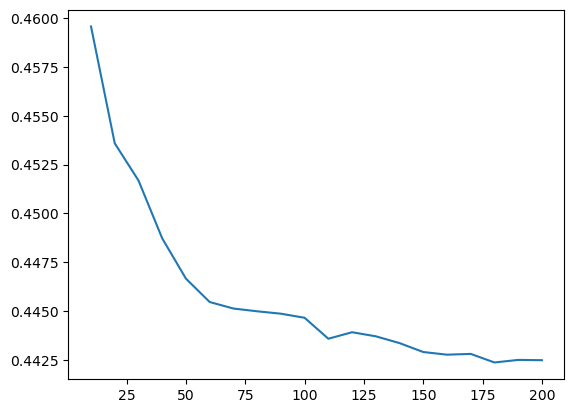

In [29]:
plt.plot(df_scores['n_estimators'], df_scores['rmse'])
plt.show()

In [ ]:
scores_depth = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=d,
            random_state=1,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        scores_depth.append((d, n, rmse))

In [ ]:
columns_depth = ['max_depth', 'n_estimators', 'rmse']
df_scores_depth = pd.DataFrame(scores_depth, columns=columns_depth)

In [ ]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores_depth[df_scores_depth.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()
plt.show()

In [ ]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

In [ ]:
feature_names = dv.get_feature_names_out()
fi = pd.Series(rf.feature_importances_, index=feature_names)
print(fi[['vehicle_weight', 'horsepower', 'acceleration', 'engine_displacement']].sort_values(ascending=False))

In [ ]:
xgb.DMatrix(X_train, label=y_train)

In [ ]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [ ]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [ ]:
y_pred = model.predict(dval)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

In [ ]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [ ]:
y_pred = model.predict(dval)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse